In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import os, sys

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

sys.path.append('../')
from ImitationLearner import ImitationLearner, evaluate_performance

In [20]:
results_dir = 'offline_results_TMY3'

if not os.path.exists(results_dir):
    os.mkdir(results_dir)
    
weights_dir = os.path.join(results_dir, 'weights')
if not os.path.exists(weights_dir):
    os.mkdir(weights_dir)

#### Create dirs for saving

In [21]:
imit_results = results_dir + "/Imit_{}.pkl"
f_weights = results_dir + "/weights/F-{}.npy"
bd_weights = results_dir + "/weights/Bd-{}.npy"
loss_fname = results_dir + "/Imit_loss.pkl"

#### Specify the names of state, control and target variables

In [22]:
# Modify here: Outputs from EnergyPlus; Match the variables.cfg file.
obs_name = [
    "Outdoor Temp.", 
    "Outdoor RH", 
    "Wind Speed", 
    "Wind Direction", 
    "Diff. Solar Rad.", 
    "Direct Solar Rad.", 
    "Htg SP", 
    "Clg SP", 
    "Indoor Temp.", 
    "Indoor Temp. Setpoint", 
    "PPD", 
    "Occupancy Flag", 
    "Coil Power", 
    "HVAC Power", 
    "Sys In Temp.", 
    "Sys In Mdot", 
    "OA Temp.", 
    "OA Mdot", 
    "MA Temp.", 
    "MA Mdot", 
    "Sys Out Temp.", 
    "Sys Out Mdot"
]

# Modify here: Change based on the specific control problem
state_name = ["Indoor Temp."]
dist_name = ["Outdoor Temp.", "Outdoor RH", "Wind Speed", "Wind Direction", "Diff. Solar Rad.", "Direct Solar Rad.", "Occupancy Flag"]
# Caveat: The RL agent controls the difference between Supply Air Temp. and Mixed Air Temp., i.e. the amount of heating from the heating coil. But, the E+ expects Supply Air Temp. Setpoint.
ctrl_name = ["Delta T"]
target_name = ["Indoor Temp. Setpoint"]

##### Load data

In [23]:
dataset_name = "simulation_results/Sim-TMY3.pkl"

# Read Historical Data
dataset = pd.read_pickle(dataset_name)
dataset.index

DatetimeIndex(['1991-01-01 00:00:00', '1991-01-01 00:15:00',
               '1991-01-01 00:30:00', '1991-01-01 00:45:00',
               '1991-01-01 01:00:00', '1991-01-01 01:15:00',
               '1991-01-01 01:30:00', '1991-01-01 01:45:00',
               '1991-01-01 02:00:00', '1991-01-01 02:15:00',
               ...
               '1991-04-01 21:45:00', '1991-04-01 22:00:00',
               '1991-04-01 22:15:00', '1991-04-01 22:30:00',
               '1991-04-01 22:45:00', '1991-04-01 23:00:00',
               '1991-04-01 23:15:00', '1991-04-01 23:30:00',
               '1991-04-01 23:45:00', '1991-04-02 00:00:00'],
              dtype='datetime64[ns]', length=8737, freq=None)

In [24]:
target = dataset[target_name]
disturbance = dataset[dist_name]
# Min-Max Normalization
disturbance = (disturbance-disturbance.min())/(disturbance.max()-disturbance.min())

dataset["Delta T"] = dataset["Sys Out Temp."]-dataset["MA Temp."]

# Train-Test Split
n_samples = len(dataset)
n_train = int(0.7*n_samples)
n_test = n_samples - n_train
train_set = dataset[:n_train]
test_set = dataset[n_train:]

#### Specify hyperparameters

In [25]:
# Training Hyperparams
epochs = 20
step   = 900   # 15 minutes
bs     = 256   # batch size 
lr     = 5e-4  # learning rate

# MPC Hyperparams
u_upper = 5
u_lower = 0

n_state = len(state_name)    # State variables
n_ctrl  = len(ctrl_name)      # The variable that the RL agent controls
n_dist  = len(dist_name)      # Disturbance variables 

#### Define the training loop

In [9]:
def train():
    # x is state and u is action
    # true is the expert (EPlus) and pred is the learner
    x_true = []
    u_true = []
    x_pred = []
    u_pred = []

    # the loss function includes diff between both state and actions
    train_state_loss = []
    train_action_loss = []
    for i in range(n_train): # By number of entries in the historical data
        idx = np.random.randint(n_train)
        cur_time = train_set.index[idx]

        expert_moves = train_set[cur_time:cur_time+pd.Timedelta(seconds = step)]
        if len(expert_moves)<2:
            print(cur_time)
            continue

        expert_state = torch.tensor(expert_moves[state_name].values).reshape(-1, n_state) # 2 x n_state
        expert_action = torch.tensor(expert_moves[ctrl_name].values).reshape(-1, n_ctrl) # 2 x n_ctrl
        x_true.append(expert_state[-1])
        u_true.append(expert_action[0])

        obs = train_set.loc[cur_time]
        x_init = torch.tensor(np.array([obs[name] for name in state_name])).unsqueeze(0) # n_batch x n_state, i.e. 1 x n_state
        C, c = learner.Cost_function(cur_time)
        learner_state, learner_action = learner.forward(x_init, C, c, cur_time)

        # Predict next state based on expert's action
        next_state = learner.predict(x_init.squeeze(0), expert_action[0], cur_time)
        x_pred.append(next_state)
        u_pred.append(learner_action)

        if (i % bs == 0) & (i>0):
            x_true = torch.stack(x_true).reshape(-1, n_state)
            u_true = torch.stack(u_true).reshape(-1, n_ctrl)
            x_pred = torch.stack(x_pred).reshape(-1, n_state)
            u_pred = torch.stack(u_pred).reshape(-1, n_ctrl)
            b_state_loss, b_action_loss = learner.update_parameters(x_true, u_true, x_pred, u_pred)
            train_state_loss.append(b_state_loss)
            train_action_loss.append(b_action_loss)
            x_true = []
            u_true = []
            x_pred = []
            u_pred = []
    return train_state_loss, train_action_loss

In [10]:
def evaluate(losses, train_state_loss, train_action_loss):
    x_true = []
    u_true = []
    x_pred = []
    u_pred = []
    timeStamp = []
    for idx in range(n_test):
        cur_time = test_set.index[idx]
        expert_moves = test_set[cur_time:cur_time+pd.Timedelta(seconds = step)]
        if len(expert_moves)<2:
            print(cur_time)
            continue
        expert_state = torch.tensor(expert_moves[state_name].values).reshape(-1, n_state) # 2 x n_state
        expert_action = torch.tensor(expert_moves[ctrl_name].values).reshape(-1, n_ctrl) # 2 x n_ctrl
        x_true.append(expert_state[-1])
        u_true.append(expert_action[0])

        timeStamp.append(cur_time+pd.Timedelta(seconds = step))

        obs = test_set.loc[cur_time]
        x_init = torch.tensor(np.array([obs[name] for name in state_name])).unsqueeze(0) # 1 x n_state
        C, c = learner.Cost_function(cur_time)
        learner_state, learner_action = learner.forward(x_init, C, c, cur_time)
        next_state = learner.predict(x_init.squeeze(0), expert_action[0], cur_time)
        x_pred.append(next_state.detach())
        u_pred.append(learner_action.detach())

    x_true = torch.stack(x_true).reshape(-1, n_state)
    u_true = torch.stack(u_true).reshape(-1, n_ctrl)
    x_pred = torch.stack(x_pred).reshape(-1, n_state)
    u_pred = torch.stack(u_pred).reshape(-1, n_ctrl)
    val_state_loss, val_action_loss = evaluate_performance(x_true, u_true, x_pred, u_pred)
    print("At Epoch {0}, the loss from the state is {1} and from the action is {2}".format(epoch, val_state_loss, val_action_loss))
    losses.append((np.mean(train_state_loss), np.mean(train_action_loss), val_state_loss, val_action_loss))

    record = pd.DataFrame(torch.cat((x_pred, x_true, u_pred, u_true), dim = 1).numpy(), index = np.array(timeStamp), columns = record_name)
    record_df = pd.DataFrame(np.array(record), index = np.array(timeStamp), columns = record_name)
    record_df.to_pickle(imit_results.format(epoch))

    # Save weights
    F_hat = learner.F_hat.detach().numpy()
    Bd_hat = learner.Bd_hat.detach().numpy()
    
    np.save(f_weights.format(epoch), F_hat)
    np.save(bd_weights.format(epoch), Bd_hat)

    return losses

In [11]:
def save(losses):
    # Save losses at each epoch
    losses_df = pd.DataFrame(np.array(losses), index = np.arange(epochs), columns = losses_name)
    losses_df.to_pickle(loss_fname)

In [12]:
import time

In [13]:
learner = ImitationLearner(n_state, n_ctrl, n_dist, disturbance, target, u_upper, u_lower, step, lr)
losses = []
record_name =["Learner nState", "Expert nState", "Learner action", "Expert action"]
losses_name = ["train_state_loss", "train_action_loss", "val_state_loss", "val_action_loss"]
st = time.time()


for epoch in range(epochs):
    state_loss, action_loss = train()
    losses = evaluate(losses, state_loss, action_loss)

print( 'RUN TIME', time.time() - st) 
save(losses)

From state 0.2904834231129191, From action 4.070611414731038
From state 0.30771832541279565, From action 4.740635477366998
From state 0.2741837719239485, From action 5.494941314045519
From state 0.36907569660739314, From action 4.706221343922409
From state 0.25224679965809166, From action 5.059240711250922
From state 0.2981735878582616, From action 3.8561468513120416
From state 0.29281397284775534, From action 3.7583354956493222
From state 0.2389355052756666, From action 4.314356912704886
From state 0.3412856819695712, From action 5.166483619174116
From state 0.2734853539480786, From action 4.783078922740403
From state 0.3116837458764624, From action 5.1756207366158336
From state 0.25044924132137, From action 4.509159748081299
From state 0.2986114213828, From action 4.4431614286445225
From state 0.2759272601736097, From action 4.624375635636536
From state 0.32255056374356555, From action 4.493574452230898
From state 0.34835928228829316, From action 4.400835766203584
From state 0.351418

From state 0.2992976406816726, From action 4.2660711506897435
From state 0.24950559358163543, From action 4.421000619183409
From state 0.23921548147207033, From action 4.222678012378065
From state 0.3147199927573029, From action 4.035982006684737
From state 0.23608582131534722, From action 4.200744225213347
From state 0.241959963493468, From action 3.765866637830765
From state 0.32300484603070556, From action 4.475326716146825
From state 0.23492905268093886, From action 3.885545503484182
From state 0.2577850938487406, From action 4.016137724369116
From state 0.25267487651357595, From action 4.085681379710872
From state 0.25694097875386185, From action 3.8344774645551416
From state 0.24910187746347906, From action 4.821053800003234
From state 0.3126153762055798, From action 4.212253528209832
From state 0.2620139818522957, From action 3.5868758421581655
From state 0.29998187311482194, From action 3.9826565612164186
From state 0.2541486219886306, From action 5.059755154634042
From state 0

From state 0.19887800326450028, From action 3.6263078679246257
From state 0.21779095856205957, From action 4.366280868450946
From state 0.24760386239754367, From action 3.978962328118148
From state 0.19373556002882944, From action 4.398022358173511
From state 0.3321746125564367, From action 4.036294779865946
From state 0.3419370478389944, From action 4.5590576290508835
From state 0.1775834072693861, From action 4.15616236310879
From state 0.2865952163797197, From action 3.9029537989910237
From state 0.2833492876336336, From action 4.4288910049620736
From state 0.2763662133771417, From action 4.854882510379085
From state 0.3281866906407034, From action 4.847336144337945
From state 0.3359761512240726, From action 4.800495937259428
From state 0.2281482852467009, From action 4.637373521560958
1991-03-05 16:30:00
From state 0.2804166178560929, From action 4.443096871352839
1991-04-02 00:00:00
At Epoch 10, the loss from the state is 0.21542784422810923 and from the action is 1.98701886558084

From state 0.19066807961507148, From action 4.143506398426987
From state 0.2789613045175504, From action 4.340563666583321
From state 0.20764312747848465, From action 4.659774495493792
From state 0.19301832179521675, From action 3.3720211604964483
From state 0.2054598432879253, From action 4.10087903332888
From state 0.19902303620401296, From action 5.0866896490651365
From state 0.20473119029446407, From action 4.196029240457569
From state 0.21553615393100573, From action 4.089580744268644
From state 0.17024582958746665, From action 3.6037517521185785
1991-04-02 00:00:00
At Epoch 15, the loss from the state is 0.2041938911484612 and from the action is 2.050000009562913
From state 0.2517857456720981, From action 3.384054265380504
From state 0.20218469228648095, From action 4.458638709015228
1991-03-05 16:30:00
From state 0.24343124192612192, From action 4.499474366153546
From state 0.21727004675413383, From action 4.272322035259586
From state 0.14002217448673604, From action 4.473640204

# Plots

In [14]:
def plotPerf(rl, baseline, start_time, end_time):
    fig = plt.figure(figsize=(20,6))

    plt.subplot(2,1,1)
    plt.plot(baseline["Indoor Temp."], 'b-', label="EnergyPlus")
    plt.plot(rl["Indoor Temp."],'r-', label="Gnu-RL")
    plt.plot(rl["Indoor Temp. Setpoint"], 'k--')
    plt.legend()
    plt.ylabel("State\nIndoor Temp.", fontsize = 16)
    plt.xlim([start_time, end_time])

    plt.subplot(2,1,2)
    plt.plot(baseline["Sys Out Temp."],'b', label ="EnergyPlus")
    plt.plot(rl["Sys Out Temp."], 'r', label ="Gnu-RL")
    plt.plot(baseline["Occupancy Flag"]*30, 'k--', label= "Occupancy Flag")
    plt.xlim([start_time, end_time])
    plt.ylabel("Action\nSupply Air Temp.", fontsize = 16)
    plt.legend()

Text(0.5,0,'Number of Epoches')

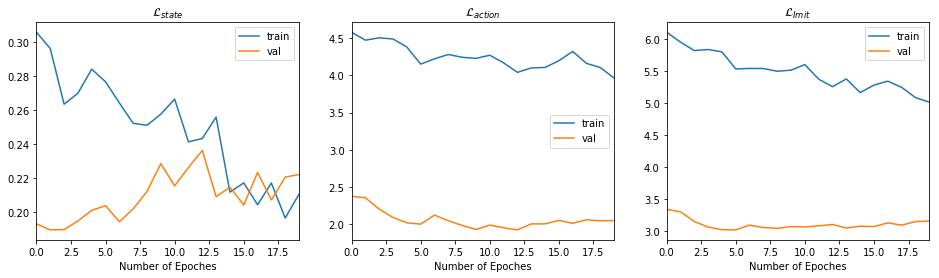

In [17]:
filePath = "{}/".format(results_dir)
lam = 5 
imit_loss = pd.read_pickle(filePath+"Imit_loss.pkl")

fig = plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.title("$\mathcal{L}_{state}$")
plt.plot(imit_loss["train_state_loss"], label="train")
plt.plot(imit_loss["val_state_loss"], label = "val")
plt.legend()
plt.xlim((0, 19))
plt.xlabel("Number of Epoches")

plt.subplot(1,3,2)
plt.title("$\mathcal{L}_{action}$")
plt.plot(imit_loss["train_action_loss"], label="train")
plt.plot(imit_loss["val_action_loss"], label = "val")
plt.legend()
plt.xlim((0, 19))
plt.xlabel("Number of Epoches")

plt.subplot(1,3,3)
plt.title("$\mathcal{L}_{Imit}$")
plt.plot(lam* imit_loss["train_state_loss"]+ imit_loss["train_action_loss"], label="train")
plt.plot(lam* imit_loss["val_state_loss"]+imit_loss["val_action_loss"], label = "val")
plt.legend()
plt.xlim((0, 19))
plt.xlabel("Number of Epoches")

In [18]:
# Selected Epoch
epoch = 16
imit_record = pd.read_pickle(filePath+"Imit_{}.pkl".format(epoch))

imit_record["Hour"] = pd.Series([time.hour for time in imit_record.index], index = imit_record.index)
imit_record["Occupancy Flag"] = (imit_record["Hour"]>=8) & (imit_record["Hour"]< 18)
imit_record["Indoor Temp. Setpoint"] = pd.Series([22.5 if occupied==1 else 12.8 for occupied in imit_record["Occupancy Flag"]], index = imit_record.index)

/Users/Gaby/anaconda3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


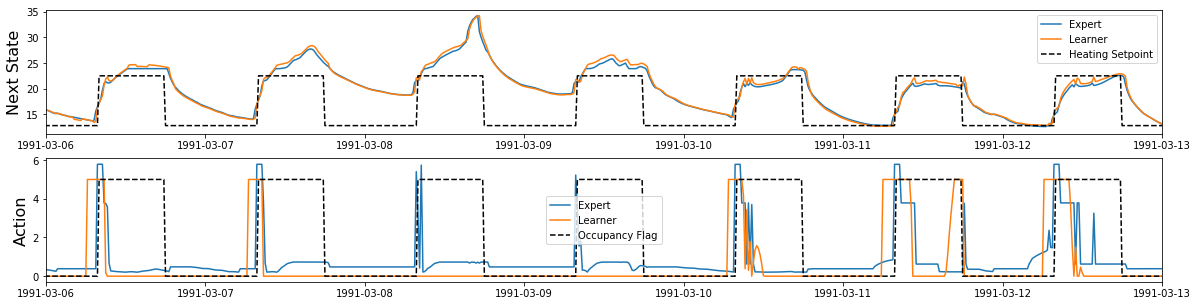

In [19]:
start_time = pd.datetime(year = 1991, month = 3, day = 6)
end_time = start_time + pd.Timedelta(days = 7)

fig = plt.figure(figsize=(20,5))
plt.subplot(2,1,1)
plt.plot(imit_record["Expert nState"], label = "Expert")
plt.plot(imit_record["Learner nState"], label = "Learner")
plt.plot(imit_record["Indoor Temp. Setpoint"], "k--", label = "Heating Setpoint")
plt.ylabel("Next State", fontsize = 16)
plt.xlim((start_time, end_time))
plt.legend()

plt.subplot(2,1,2)
plt.plot(imit_record["Expert action"], label = "Expert")
plt.plot(imit_record["Learner action"], label = "Learner")
plt.plot(imit_record["Occupancy Flag"]*5, 'k--', label = "Occupancy Flag")
plt.ylabel("Action", fontsize = 16)
plt.xlim((start_time, end_time))
plt.legend()